In [391]:
import numpy as np
import torch

In [392]:
torch.manual_seed(0)
from torchvision import transforms
import torch.nn.functional as F 
from torch import nn
import sys

sys.path.insert(1, '/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/visualisation')
import json_ImExport
import LogDataImport

data=json_ImExport.loadData("/Users/leonkiesgen/Documents/Python/Kappa_variation_vmax100.json")

data2=LogDataImport.get_data("/Users/leonkiesgen/Documents/Python/mod_local_trajectory/logs/ltpl/2019_12_01/15_00_59_data.csv")


mean, std = (0.5), (0.5)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])




In [393]:
class FMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(99,300)
        self.fc2 = nn.Linear(300,200)
        self.fc3 = nn.Linear(200,150)
        self.fc4 = nn.Linear(150,98)

    def forward(self,x):

        x = F.leaky_relu(self.fc1(x),negative_slope=0.05)
        x = F.leaky_relu(self.fc2(x),negative_slope=0.05)
        x = F.leaky_relu(self.fc3(x),negative_slope=0.05)
        x = F.leaky_relu(self.fc4(x),negative_slope=0.05)
        #x= F.log_softmax(x_dim=1)

        return x

In [394]:
import random
model=FMNIST()

class Normalize():

    def __init__(self,data,scale=None):


        if scale is None:
            self.max=np.max(np.abs(data))
        else:
            self.max=scale
        print("Max is: ",self.max )

    def __call__(self,x):
        return x/self.max

    def normal(self,x):
        return x*self.max


def prepareData(data):
    
    prepareddata=[]
    for item in data:
        inpdata=[]
        #print(item)
        #print(item["v_ini"])
        inpdata.append(item["v_ini"])
        inpdata.append(item["v_max"])
        inpdata.append(item["Power"])   
        inpdata.extend(item["Kappa"])

        #print("Input: ",inpdata)
        label=item["V_op"]

        inpdata=torch.Tensor(inpdata)
        label=torch.Tensor(label)

        tupledata=(inpdata,label)
        prepareddata.append((inpdata,label))
    

    return prepareddata


def prepareLogData(data):
    lowestLen=200
    prepareddata=[]

    allkappa=[]
    for item in data:
        allkappa.extend(item[0])
    
    #Initialize Nomalizer
    kappaNormalize=Normalize(allkappa)
    VelNormalize=Normalize(None,scale=70)

    for item in data:
        inpdata=[]
        lowestLen= len(item[1]) if len(item[1])< lowestLen else lowestLen

        
        inpdata.append(VelNormalize(item[1][0]))#item["v_ini"])
        #print("Item 1: ", inpdata)
        #inpdata.append()#item["v_max"])
        #inpdata.append()#item["Power"]) 

        kappatmp=kappaNormalize(item[0][:98])
        inpdata.extend(kappatmp) #Kappa
        



        inpdata=torch.Tensor(inpdata)

        label=np.array(item[1][:98])

        label=torch.Tensor(VelNormalize(label)) #V_opt

        

        tupledata=(inpdata,label)
        prepareddata.append((inpdata,label))
    
    print(lowestLen)
    return prepareddata

traindata=prepareLogData(data2)
random.shuffle(traindata)
#print(traindata[1000][1])
#print(len(traindata))

Max is:  0.044784975560085524
Max is:  70
98


In [395]:
from IPython.core.debugger import set_trace

from torch import optim
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

OUTSHOW=None

num_epochs = 25
train_tracker, test_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0
    cum_loss2 = 0
    
    for batch, (inp, vel) in enumerate(traindata,1):


        optimizer.zero_grad()
        output = model(inp)

        

        loss = criterion(output, vel)

        loss.backward()
        optimizer.step()

        cum_loss += loss.item()
        

    train_tracker.append(cum_loss/len(traindata))
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss2/len(traindata)} | " ,end="")
    
    test_loss = 0
    num_correct = 0
    total = 0
    
    for batch, (inp, vel) in enumerate(traindata,1):
        
        output3 = model(inp)
        batch_loss = criterion(output3, vel)        
        test_loss += batch_loss.item()
    
        
    
    test_tracker.append(test_loss/len(traindata))
    print(f"Test loss: {test_loss/len(traindata)} | ")
    '''
    #accuracy_tracker.append(num_correct/total)
    #print(f'Accuracy : {num_correct/total}')     
    

#print(f'\nNumber correct : {num_correct}, Total : {total}')
#print(f'Accuracy of the model after 30 epochs on the 10000 test images: {num_correct * 100 / total}% ')
    '''
    

Epoch(1/25) | Training loss: 0.0 |Test loss: 0.2587284967660523 | 
Epoch(2/25) | Training loss: 0.0 |Test loss: 0.14458686682570787 | 
Epoch(3/25) | Training loss: 0.0 |Test loss: 0.08435000769385138 | 
Epoch(4/25) | Training loss: 0.0 |Test loss: 0.05313605566439107 | 
Epoch(5/25) | Training loss: 0.0 |Test loss: 0.03936731475494707 | 
Epoch(6/25) | Training loss: 0.0 |Test loss: 0.03348740633675351 | 
Epoch(7/25) | Training loss: 0.0 |Test loss: 0.02861912035495916 | 
Epoch(8/25) | Training loss: 0.0 |Test loss: 0.0242986245777708 | 
Epoch(9/25) | Training loss: 0.0 |Test loss: 0.020938241881103548 | 
Epoch(10/25) | Training loss: 0.0 |Test loss: 0.018818151545658763 | 
Epoch(11/25) | Training loss: 0.0 |Test loss: 0.01707185268279048 | 
Epoch(12/25) | Training loss: 0.0 |Test loss: 0.01550150426133443 | 
Epoch(13/25) | Training loss: 0.0 |Test loss: 0.014278691492976742 | 
Epoch(14/25) | Training loss: 0.0 |Test loss: 0.013348231634539917 | 
Epoch(15/25) | Training loss: 0.0 |Test l

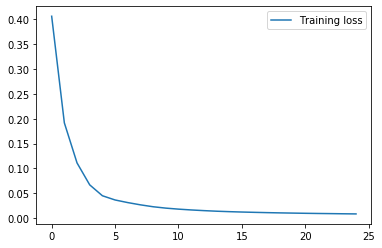

In [396]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
#plt.plot(test_tracker, label='Test loss')
plt.legend()

In [397]:
def predict(testexample,NN=model):
    VelNormalize= Normalize(None,70)

    criterion = nn.L1Loss()
    pData=testexample[0]
    pred=NN(pData[0])
    loss=criterion(pred,pData[1])

    %matplotlib inline


    pred=VelNormalize.normal(np.array(pred.tolist()))
    real=VelNormalize.normal(np.array(pData[1]))

    plt.plot(pred,label="Pred")
    plt.plot(real,label= "Real_Optimizer")
    print("Loss:", loss.item())


def cumloss(example,NN=model):
    criterion = nn.L1Loss()
    cumloss=0
    i=0
    for (inp,label) in example:
        optimizer.zero_grad()
        pred=model.forward(inp)
        loss=criterion(pred,label)
        cumloss+= loss.item()
        i+=1
    return cumloss,i

Max is:  70
Loss: 0.0034660666715353727


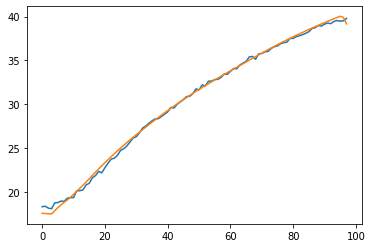

In [398]:

predict([traindata[35]],model)
#(cmloss,i)=cumloss(traindata)

#print("Cmloss: ",cmloss," Number ",i)

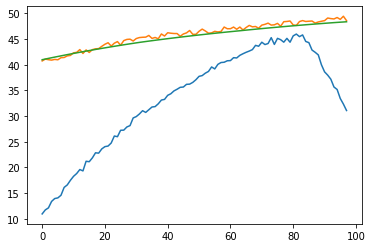

In [283]:
%matplotlib inline

plt.plot(model.forward(traindata[1200][0]).tolist())
plt.plot(OUTSHOW.tolist(),label="Pred")
plt.plot(traindata[1200][1].tolist(),label= "Real_Optimizer")

In [405]:
name="NN300200150_2"

In [407]:
#Save MODEL
PATH="/Users/leonkiesgen/Documents/Python/BA_Optimization_ML/MaschineLearning/mlModels/"+ name
torch.save(model.state_dict(), PATH+".pt")
torch.save(model,PATH+".pth")

/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FMNIST. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [406]:
#Load MODEL with same Structure
model=FMNIST()
model.load_state_dict(torch.load(PATH+"pt"))
model.eval()

FMNIST(
  (fc1): Linear(in_features=99, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=150, bias=True)
  (fc4): Linear(in_features=150, out_features=98, bias=True)
)

In [411]:
#Load MODEL with different Structure
model2=torch.load(PATH+".pth")
model2.eval()

FMNIST(
  (fc1): Linear(in_features=99, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=150, bias=True)
  (fc4): Linear(in_features=150, out_features=98, bias=True)
)

In [412]:
model2(traindata[37][0])

tensor([0.7132, 0.7150, 0.7088, 0.7104, 0.7176, 0.7130, 0.7147, 0.7129, 0.7137,
        0.7104, 0.7108, 0.7164, 0.7106, 0.7113, 0.7148, 0.7166, 0.7179, 0.7168,
        0.7167, 0.7126, 0.7163, 0.7186, 0.7160, 0.7159, 0.7160, 0.7200, 0.7182,
        0.7209, 0.7220, 0.7221, 0.7215, 0.7233, 0.7231, 0.7212, 0.7242, 0.7237,
        0.7249, 0.7250, 0.7248, 0.7250, 0.7230, 0.7249, 0.7217, 0.7249, 0.7252,
        0.7267, 0.7259, 0.7239, 0.7245, 0.7258, 0.7259, 0.7272, 0.7278, 0.7304,
        0.7305, 0.7294, 0.7268, 0.7259, 0.7285, 0.7300, 0.7299, 0.7313, 0.7281,
        0.7309, 0.7320, 0.7322, 0.7355, 0.7340, 0.7284, 0.7351, 0.7316, 0.7332,
        0.7350, 0.7342, 0.7324, 0.7330, 0.7333, 0.7320, 0.7308, 0.7344, 0.7303,
        0.7330, 0.7301, 0.7353, 0.7304, 0.7341, 0.7321, 0.7314, 0.7378, 0.7329,
        0.7330, 0.7335, 0.7341, 0.7331, 0.7377, 0.7367, 0.7380, 0.7347],
       grad_fn=<LeakyReluBackward0>)